### Libraries

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from pred_additional_functions import Diagnose_MV_Numerical
from pred_pipeline import columns_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, OneHotEncoder
import matplotlib.pyplot as plt
import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from pred_pipeline import columns_transformer
from sklearn.model_selection import GridSearchCV, KFold
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

### Data upload & cleaning (Missing values and outliers management)

In [2]:
# Loading data
df = pd.read_csv('../../BC_A&A_with_ATD.csv', sep=',')

In [3]:
# Identifying the outliers
Q1 = df.ATD.quantile(0.25)
Q3 = df.ATD.quantile(0.75)
IQR = Q3-Q1
upper_bound = Q3 + 2.5 * IQR
lower_bound = Q1 - 1.5 * IQR

is_outlier = (df['ATD'] > upper_bound) | (df['ATD'] < lower_bound)
df['Id_Outlier'] = is_outlier

outlier_count = df['Id_Outlier'].sum()
print("Outliers: " + str(outlier_count))

# Identifying the missing values
df = df.replace('\\N', np.nan)
df[['pickup_distance', 'dropoff_distance']]= df[['pickup_distance', 'dropoff_distance']].replace('0', np.nan)
df['Id_NA']=np.where(df.isnull().any(axis=1), True, False)

missing_count = df['Id_NA'].sum()
print("\nMissing values: " + str(missing_count)+'\n')

# Exploring the distribution of missing values and outliers
df_combinations = df.groupby(['Id_Outlier','Id_NA']).size().reset_index(name='Count')
print(df_combinations)

print('\nColumns information:')
print(df.info())

Outliers: 15355

Missing values: 83650

   Id_Outlier  Id_NA   Count
0       False  False  904119
1       False   True   80526
2        True  False   12231
3        True   True    3124

Columns information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   region                             1000000 non-null  object 
 1   territory                          1000000 non-null  object 
 2   country_name                       1000000 non-null  object 
 3   workflow_uuid                      1000000 non-null  object 
 4   driver_uuid                        987450 non-null   object 
 5   delivery_trip_uuid                 1000000 non-null  object 
 6   courier_flow                       992451 non-null   object 
 7   restaurant_offered_timestamp_utc   999835 non-null   object 
 8   order_final_stat

In [4]:
# Deleting outliers
print("Size before deleting: " + str(df.shape))
df = df[df['Id_Outlier']==False]
print("Final size: " + str(df.shape))

Size before deleting: (1000000, 17)
Final size: (984645, 17)


In [5]:
# Veifying that the missing values for the categorical columns are not related with a specific column class
for col in ['territory', 'courier_flow', 'geo_archetype', 'merchant_surface']:
    print(f'\n\nMissing values analysis for column: {col}\n')
    df_nan = df.groupby(col).agg(
        Total_NaNs=('Id_NA', 'sum'),
        Total_Records=('Id_NA', 'count') 
    ).reset_index()

    df_nan['Percentage'] = (
        round(df_nan['Total_NaNs'] / df_nan['Total_Records'] * 100, 2)
    )

    print(df_nan)



Missing values analysis for column: territory

            territory  Total_NaNs  Total_Records  Percentage
0             Central       36421         368597        9.88
1  Long Tail - Region        5139          67593        7.60
2               North       16043         234855        6.83
3          South East       10170         147613        6.89
4                West       12753         165987        7.68


Missing values analysis for column: courier_flow

  courier_flow  Total_NaNs  Total_Records  Percentage
0        Fleet          43           1184        3.63
1    Logistics        2783          61597        4.52
2    Motorbike       56842         822412        6.91
3    Onboarder          15            281        5.34
4          SUV          56            631        8.87
5     UberEats       13355          87962       15.18
6        UberX         120           3266        3.67


Missing values analysis for column: geo_archetype

      geo_archetype  Total_NaNs  Total_Records  

The test is contrasting the next:

- Ho: There is no significant difference between the attributes

- Ha: There is a significant difference between the attributes

If the p-test result is lower that our significance level, we can 


- - - - - - - - - - ATD - - - - - - - - - 
Diagnosis Analysis of Missing Values for ATD:


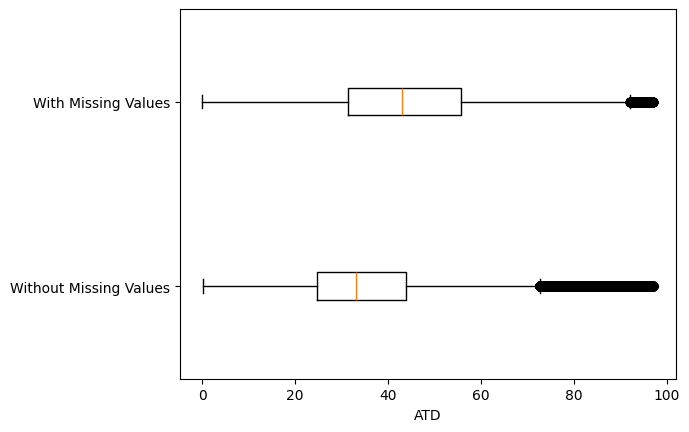

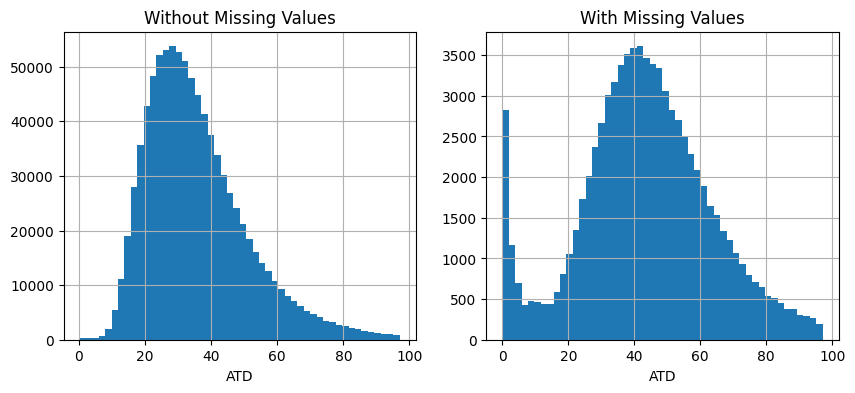

p-value of t-test: 0.0


In [6]:
# Verifying that the missing values are not modifying the ATD
df[['Id_NA']] = df[['Id_NA']].replace(True, np.nan)

numerical_attributes = ['ATD']
missing_values=df.Id_NA.isna()

for att in numerical_attributes:
    print('\n- - - - - - - - - - '+att+' - - - - - - - - - ')
    print('Diagnosis Analysis of Missing Values for {}:'.format(att))
    Diagnose_MV_Numerical(df,att,missing_values)

In [7]:
# Deleting missing values
print("Size before deleting: " + str(df.shape))
df = df[df['Id_NA']==False]
print("Final size: " + str(df.shape))

# Deleting ID columns
del(df['Id_NA'])
del(df['Id_Outlier'])

Size before deleting: (984645, 17)
Final size: (904119, 17)


In [8]:
#Align the types of columns
str_float_columns = {
    'region': str,
    'territory': str,
    'country_name': str,
    'workflow_uuid': str,
    'driver_uuid': str,
    'delivery_trip_uuid': str,
    'courier_flow': str,
    'geo_archetype': str,
    'merchant_surface': str,
    'pickup_distance': float,
    'dropoff_distance': float,
    'ATD': float}

date_columns = ['restaurant_offered_timestamp_utc', 
                'order_final_state_timestamp_local', 
                'eater_request_timestamp_local']

df = df.astype(str_float_columns)

df['restaurant_offered_timestamp_utc'] = (df['restaurant_offered_timestamp_utc'].str.replace('.000', '', regex=False)) # Removing milliseconds for uniformity
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S', errors='coerce')

df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 904119 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   region                             904119 non-null  object        
 1   territory                          904119 non-null  object        
 2   country_name                       904119 non-null  object        
 3   workflow_uuid                      904119 non-null  object        
 4   driver_uuid                        904119 non-null  object        
 5   delivery_trip_uuid                 904119 non-null  object        
 6   courier_flow                       904119 non-null  object        
 7   restaurant_offered_timestamp_utc   904119 non-null  datetime64[ns]
 8   order_final_state_timestamp_local  904119 non-null  datetime64[ns]
 9   eater_request_timestamp_local      904119 non-null  datetime64[ns]
 10  geo_archetype            

,region,territory,country_name,workflow_uuid,driver_uuid,delivery_trip_uuid,courier_flow,restaurant_offered_timestamp_utc,order_final_state_timestamp_local,eater_request_timestamp_local,geo_archetype,merchant_surface,pickup_distance,dropoff_distance,ATD
0,Mexico,South East,Mexico,8c393c94-9282-41a6-a885-7a6e84b470d7,d16e401c-795d-4295-96c0-85ca08ad8c42,715f96aa-0a31-46f6-b856-6ea6f87affad,Motorbike,2025-04-06 19:35:50,2025-04-06 13:48:48,2025-04-06 13:35:50,Drive momentum,Tablet,0.643,1.651,12.966667
1,Mexico,South East,Mexico,b156dd16-274f-46d1-ac6f-4c24ca43df69,06299354-23ec-4173-83dc-d6bd32a420e1,ac985454-0e6f-4695-a68b-755c60c2afd7,Motorbike,2025-04-11 22:30:56,2025-04-11 16:47:48,2025-04-11 16:30:56,Drive momentum,Tablet,0.812,1.733,16.866667
2,Mexico,South East,Mexico,87a8081b-b735-4daf-8452-3943a9d9ca24,188214a6-3813-44d5-9694-0ae69dfdd7e5,14b274b9-924e-4da7-8803-69558a33559d,Motorbike,2025-04-06 23:15:05,2025-04-06 17:34:49,2025-04-06 17:15:05,Drive momentum,Tablet,1.966,1.605,19.733333
3,Mexico,South East,Mexico,78f0e92c-fa45-4215-8c3f-703b8691b6eb,5c7cbb34-116b-4665-aaf3-7f02394c0ff8,ee4faf69-bfff-421a-a163-29dfa4156fc4,Motorbike,2025-04-19 02:38:58,2025-04-18 21:21:55,2025-04-18 20:38:58,Drive momentum,Tablet,3.010,4.771,42.950000
4,Mexico,Central,Mexico,e0b2324b-f210-4e6b-82d1-979f9a208967,8b7a3bd8-9cf1-493e-9c64-303db8781045,7870b275-4541-4e09-8fe7-a47e7b506ce4,Motorbike,2025-03-03 03:33:40,2025-03-02 22:02:36,2025-03-02 21:33:40,Play offense,Tablet,0.746,4.370,28.933333
5,Mexico,Central,Mexico,ebe725fe-8637-4c7d-9203-17bc447869f6,63783d44-c63d-4051-8049-7d537be9cfe9,48c3dc45-1d07-490d-8c6e-46998b69b55f,Motorbike,2025-03-08 21:52:40,2025-03-08 16:14:25,2025-03-08 15:52:40,Build experience,POS,0.998,7.554,21.750000
6,Mexico,North,Mexico,22868230-ffb9-4393-b81d-6b961877676f,470d7620-2ad7-4973-be56-f14e890684e7,4e9a9418-7676-45b2-a6f5-d45157f0187c,Motorbike,2025-04-27 21:08:22,2025-04-27 14:36:34,2025-04-27 14:08:22,Drive momentum,Tablet,1.646,1.209,28.200000
7,Mexico,Central,Mexico,c2c84392-35b3-45f9-914f-e632561758be,ff008512-c356-4572-af05-303c52da9459,6b907551-a69d-4a20-88f3-ea09057f3f0a,Motorbike,2025-03-17 22:11:35,2025-03-17 16:43:11,2025-03-17 16:11:35,Drive momentum,Web/Mobile,1.140,3.844,31.600000
8,Mexico,North,Mexico,6b86703f-5ec3-4236-a6bf-704b9089294e,4f0f1fb9-008d-40eb-a094-a0cb77ca9263,a7b21330-e047-4778-bfed-55c50ce74ff7,UberEats,2025-03-17 03:51:03,2025-03-16 22:36:37,2025-03-16 21:51:03,Play offense,Tablet,6.748,6.436,45.566667
9,Mexico,Central,Mexico,35490f26-1e6f-45dd-b6ff-7954e2081f4e,3deb1037-6e02-4991-87ce-591ef9abd03b,bfadd10f-f5d0-4912-9044-a4398f817bb1,Motorbike,2025-03-04 19:35:12,2025-03-04 14:19:02,2025-03-04 13:35:12,Build experience,Web/Mobile,1.783,6.267,43.833333


In [9]:
# Preparing the time variable to separate it in days and hours
df['weekday'] = df['eater_request_timestamp_local'].dt.weekday
df['hour_of_day'] = df['eater_request_timestamp_local'].dt.hour

# Deleting the columns that we won't use
df=df.drop(['region', 'country_name', 'workflow_uuid', 'driver_uuid', 'delivery_trip_uuid', 'restaurant_offered_timestamp_utc', 'order_final_state_timestamp_local', 'eater_request_timestamp_local'], axis=1).reset_index(drop=True)
display(df.head(10))

,territory,courier_flow,geo_archetype,merchant_surface,pickup_distance,dropoff_distance,ATD,weekday,hour_of_day
0,South East,Motorbike,Drive momentum,Tablet,0.643,1.651,12.966667,6,13
1,South East,Motorbike,Drive momentum,Tablet,0.812,1.733,16.866667,4,16
2,South East,Motorbike,Drive momentum,Tablet,1.966,1.605,19.733333,6,17
3,South East,Motorbike,Drive momentum,Tablet,3.010,4.771,42.950000,4,20
4,Central,Motorbike,Play offense,Tablet,0.746,4.370,28.933333,6,21
5,Central,Motorbike,Build experience,POS,0.998,7.554,21.750000,5,15
6,North,Motorbike,Drive momentum,Tablet,1.646,1.209,28.200000,6,14
7,Central,Motorbike,Drive momentum,Web/Mobile,1.140,3.844,31.600000,0,16
8,North,UberEats,Play offense,Tablet,6.748,6.436,45.566667,6,21
9,Central,Motorbike,Build experience,Web/Mobile,1.783,6.267,43.833333,1,13


### Feature engineering

In [10]:
# Separating our data in training, validation and test
X = df[['territory', 'courier_flow', 'geo_archetype', 'merchant_surface', 'pickup_distance', 'dropoff_distance', 'weekday', 'hour_of_day']]
y = df[['ATD']]

Xtrain, Xtv, ytrain, ytv = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=5)
Xval, Xtest, yval, ytest = train_test_split(Xtv, ytv, train_size=0.5, shuffle=True, random_state=5)

print('Train:', Xtrain.shape, ytrain.shape)
print('Validation:', Xval.shape, yval.shape)
print('Test:', Xtest.shape, ytest.shape)

Train: (678089, 8) (678089, 1)
Validation: (113015, 8) (113015, 1)
Test: (113015, 8) (113015, 1)


In [11]:
# Validate the correct distribution of the categorical variables and identify the classes with less than 5% of the data
print("Train:")
print(round(Xtrain['territory'].value_counts(normalize=True)*100))
print(round(Xtrain['courier_flow'].value_counts(normalize=True)*100))
print(round(Xtrain['geo_archetype'].value_counts(normalize=True)*100))
print(round(Xtrain['merchant_surface'].value_counts(normalize=True)*100))

print("Validation:")
print(round(Xval['territory'].value_counts(normalize=True)*100))
print(round(Xval['courier_flow'].value_counts(normalize=True)*100))
print(round(Xval['geo_archetype'].value_counts(normalize=True)*100))
print(round(Xval['merchant_surface'].value_counts(normalize=True)*100))

# Now that we have verified we can join again the dataframes
Xtv = pd.concat([Xtrain, Xval])
ytv = pd.concat([ytrain, yval])

Train:
territory
Central               37.0
North                 24.0
West                  17.0
South East            15.0
Long Tail - Region     7.0
Name: proportion, dtype: float64
courier_flow
Motorbike    85.0
UberEats      8.0
Logistics     6.0
UberX         0.0
Fleet         0.0
SUV           0.0
Onboarder     0.0
Name: proportion, dtype: float64
geo_archetype
Drive momentum      35.0
Defend CP           30.0
Play offense        29.0
Build experience     5.0
Unspecified          1.0
Unlaunched           0.0
Name: proportion, dtype: float64
merchant_surface
POS            47.0
Tablet         28.0
Other          13.0
Web/Mobile     10.0
Unspecified     3.0
Name: proportion, dtype: float64
Validation:
territory
Central               37.0
North                 24.0
West                  17.0
South East            15.0
Long Tail - Region     7.0
Name: proportion, dtype: float64
courier_flow
Motorbike    85.0
UberEats      8.0
Logistics     7.0
UberX         0.0
Fleet         0.0
SUV

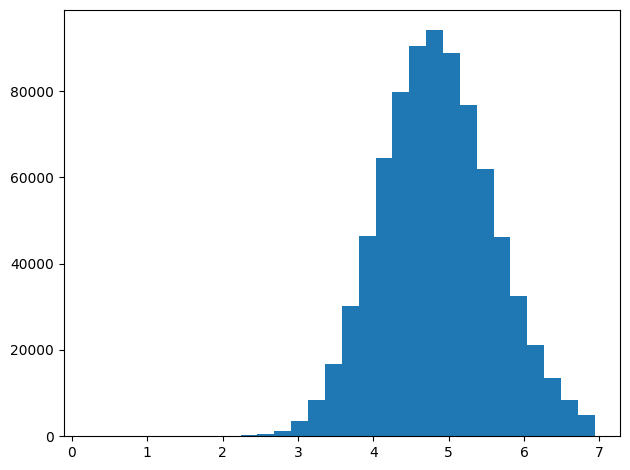

['y_target_transformer.joblib']

In [12]:
# Transforming 'y'
pt = PowerTransformer(method='yeo-johnson', standardize=False)

pt.fit(ytv.values.reshape(-1, 1))

# Transformar los conjuntos de Train, Val y Test:
ytv_transformed = pt.transform(ytv.values.reshape(-1, 1))
ytest_transformed = pt.transform(ytest.values.reshape(-1, 1))

plt.hist(ytv_transformed, bins=30)
plt.tight_layout()
plt.show()

joblib.dump(pt, 'y_target_transformer.joblib')

In [13]:
preprocessor=columns_transformer()
tmp = preprocessor.fit_transform(Xtv)

print('Original shape:', Xtv.shape)
print('Final shape:', tmp.shape)

tmp_df = pd.DataFrame(tmp, columns=['territory__territory', 'courier_flow__courier_flow_Motorbike',
       'courier_flow__courier_flow_UberEats',
       'courier_flow__courier_flow_UberX_Fleet_SUV_Onboarder',
       'geo_archetype__geo_archetype_Defend CP',
       'geo_archetype__geo_archetype_Drive momentum',
       'geo_archetype__geo_archetype_Play offense',
       'merchant_surface__merchant_surface_POS',
       'merchant_surface__merchant_surface_Tablet',
       'merchant_surface__merchant_surface_Unspecified',
       'merchant_surface__merchant_surface_Web/Mobile',
       'weekday__weekday_sin', 'weekday__weekday_cos',
       'hour_of_day__hour_of_day_sin', 'hour_of_day__hour_of_day_cos',
       'distances__pickup_distance', 'distances__dropoff_distance'])

display(Xtrain.head(5))
display(tmp_df.head(5))

Original shape: (791104, 8)
Final shape: (791104, 17)


,territory,courier_flow,geo_archetype,merchant_surface,pickup_distance,dropoff_distance,weekday,hour_of_day
510487,North,Motorbike,Play offense,Tablet,1.477,6.660,2,14
857709,West,Motorbike,Play offense,POS,1.179,1.513,2,8
149511,West,Motorbike,Drive momentum,Other,2.596,8.257,3,9
664917,North,Motorbike,Drive momentum,POS,1.105,3.570,0,13
209390,South East,Motorbike,Drive momentum,Web/Mobile,1.019,1.902,5,13


,territory__territory,courier_flow__courier_flow_Motorbike,courier_flow__courier_flow_UberEats,courier_flow__courier_flow_UberX_Fleet_SUV_Onboarder,geo_archetype__geo_archetype_Defend CP,geo_archetype__geo_archetype_Drive momentum,geo_archetype__geo_archetype_Play offense,merchant_surface__merchant_surface_POS,merchant_surface__merchant_surface_Tablet,merchant_surface__merchant_surface_Unspecified,merchant_surface__merchant_surface_Web/Mobile,weekday__weekday_sin,weekday__weekday_cos,hour_of_day__hour_of_day_sin,hour_of_day__hour_of_day_cos,distances__pickup_distance,distances__dropoff_distance
0,0.1715,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.974928,-0.222521,-0.500000,-0.866025,0.237855,0.990896
1,0.1725,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.974928,-0.222521,0.866025,-0.500000,-0.003706,-1.029666
2,0.1725,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.433884,-0.900969,0.707107,-0.707107,0.896576,1.322767
3,0.1715,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,-0.258819,-0.965926,-0.070197,0.069007
4,0.1665,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.974928,-0.222521,-0.258819,-0.965926,-0.151266,-0.762144


In [ ]:
# Random forest
preprocessor=columns_transformer()
full_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('m', RandomForestRegressor(random_state=1)) 
])

param_grid = {
    'm__n_estimators': [400], # Number of trees
    'm__max_depth': [8, 12], # Maximum tree deep
    'm__min_samples_split' : [200,50],  # Minimum sample points to create a branching
    'm__min_samples_leaf' : [200,50]  # Minimum sample points that must remain in each new branch (leaves)
}

cv_strategy = KFold(n_splits=3, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=full_pipeline_rf,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(Xtv, np.ravel(ytv_transformed))

print("Best score (Neg MSE):", -grid_search.best_score_)
print("Best hiperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'atd_prediction_model_rf.joblib')
joblib.dump(grid_search, 'atd_prediction_grid_search_rf.joblib')

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [19]:
#XGBoost
preprocessor=columns_transformer()
full_pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('m', xgb.XGBRegressor(objective='reg:squarederror', random_state=1,n_jobs=-1)) 
])

param_grid = {
    'm__n_estimators': [400],# Number of trees
    'm__max_depth': [8, 12],# Maximum tree deep
    'm__learning_rate': [0.1, 0.3],# Regularization
    'm__subsample': [0.7, 0.1],# Sample proportion
}

cv_strategy = KFold(n_splits=3, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=full_pipeline_xgb,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(Xtv, np.ravel(ytv_transformed))

print("Best score (Neg MSE):", -grid_search.best_score_)
print("Best hiperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'atd_prediction_model_xgb.joblib')
joblib.dump(grid_search, 'atd_prediction_grid_search_xgb.joblib')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score (Neg MSE): 0.3720766519403929
Best hiperparameters: {'m__learning_rate': 0.1, 'm__max_depth': 8, 'm__n_estimators': 400, 'm__subsample': 0.7}


['atd_prediction_grid_search_xgb.joblib']

In [20]:
#Features importances
columns=['territory__territory', 'courier_flow__courier_flow_Motorbike',
       'courier_flow__courier_flow_UberEats',
       'courier_flow__courier_flow_UberX_Fleet_SUV_Onboarder',
       'geo_archetype__geo_archetype_Defend CP',
       'geo_archetype__geo_archetype_Drive momentum',
       'geo_archetype__geo_archetype_Play offense',
       'merchant_surface__merchant_surface_POS',
       'merchant_surface__merchant_surface_Tablet',
       'merchant_surface__merchant_surface_Unspecified',
       'merchant_surface__merchant_surface_Web/Mobile',
       'weekday__weekday_sin', 'weekday__weekday_cos',
       'hour_of_day__hour_of_day_sin', 'hour_of_day__hour_of_day_cos',
       'distances__pickup_distance', 'distances__dropoff_distance']

model = best_model.named_steps['m']
importances = model.feature_importances_.tolist()

df_importances = pd.DataFrame({
    'Variable': columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

display(df_importances)

joblib.dump(df_importances, 'df_importances.joblib')

,Variable,Importance
16,distances__dropoff_distance,0.257227
1,courier_flow__courier_flow_Motorbike,0.148104
0,territory__territory,0.066239
2,courier_flow__courier_flow_UberEats,0.058341
7,merchant_surface__merchant_surface_POS,0.055909
4,geo_archetype__geo_archetype_Defend CP,0.055536
9,merchant_surface__merchant_surface_Unspecified,0.051111
15,distances__pickup_distance,0.042574
8,merchant_surface__merchant_surface_Tablet,0.041061
13,hour_of_day__hour_of_day_sin,0.040143


['df_importances.joblib']

In [15]:
#Multilayer Neural Network
preprocessor=columns_transformer()
full_pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('m', MLPRegressor(random_state=1, max_iter=1000)) 
])

param_grid = {
    'm__hidden_layer_sizes': [(3,),(15, 15)],# Quantity of neural networks and layers
    'm__activation': ['relu', 'tanh'], # Activation function
    'm__alpha': [0.01, 0.1]  # Regulariztion
}

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=full_pipeline_mlp,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    refit= True,
)

grid_search.fit(Xtv, np.ravel(ytv_transformed))

print("Best score (Neg MSE):", -grid_search.best_score_)
print("Best hiperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'atd_prediction_model_mlp.joblib')
joblib.dump(grid_search, 'atd_prediction_grid_search_mlp.joblib')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best score (Neg MSE): 0.37483645122537834
Best hiperparameters: {'m__activation': 'tanh', 'm__alpha': 0.01, 'm__hidden_layer_sizes': (15, 15)}


['atd_prediction_grid_search_mlp.joblib']

In [ ]:
# Example of prediction
input_df = pd.DataFrame({
        'territory': ['North'],   
        'courier_flow': ['Motorbike'],   
        'geo_archetype': ['Defend CP'], 
        'merchant_surface': ['POS'],        
        'pickup_distance': [23],
        'dropoff_distance': [22], 
        'weekday': [2],
        'hour_of_day': [3]
    })

display(input_df)

# Prediction
prediction = best_model.predict(input_df)[0]

final_prediction = pt.inverse_transform(prediction.reshape(-1, 1))
print(prediction)
print(final_prediction)